In [1]:
%matplotlib inline
import random
import time
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
from pylab import rcParams
import os
import json

In [2]:
MODEL_PATH = '../data/model_artif/'
TEST_PATHS = ["../data/export_tr_te_bb/artificial_test/Licence plates/artificial/"]
TRAIN_PATHS = ["../data/export_tr_te_bb/artificial_train/Licence plates/artificial/"]

In [3]:
EPOCH = 30

In [4]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Import data

In [5]:
def LoadImage(fname):
    return io.imread(fname) / 255.

In [6]:
def LoadAnnotation(fname):
    with open(fname) as data_file:    
        data = json.load(data_file)
    
    left = data["objects"][0]["points"]["exterior"][0][0]
    top = data["objects"][0]["points"]["exterior"][0][1]
    right = data["objects"][0]["points"]["exterior"][2][0]
    bottom = data["objects"][0]["points"]["exterior"][2][1]
    
    return [left, top, right, bottom]

In [7]:
def ReadDirFiles(dname):
    paths = []
    for file in os.listdir(os.path.join(dname, "img")):
        bname = os.path.basename(file).split(".")[0]
        
        img_name = os.path.join(dname, "img", file)
        ann_name = os.path.join(dname, "ann", bname + ".json")
        paths.append((img_name, ann_name))
    return paths

In [8]:
def ReadPaths(paths):
    all_paths = []
    for path in paths:
        temp_paths = ReadDirFiles(path)
        all_paths.extend(temp_paths)
    return all_paths

In [9]:
tr_paths = ReadPaths(TRAIN_PATHS)
te_paths = ReadPaths(TEST_PATHS)

print(len(tr_paths))
print(len(te_paths))

9784
216


In [10]:
def LoadData(paths):
    xs = []
    ys = []
    for ex_paths in paths:
        img_path = ex_paths[0]
        ann_path = ex_paths[1]
        xs.append(LoadImage(img_path))
        ys.append(LoadAnnotation(ann_path))
    
    return np.array(xs), np.array(ys)

In [11]:
X_train, Y_train = LoadData(tr_paths)
X_test, Y_test = LoadData(te_paths)

print("check shapes:")
print("X_train - ", X_train.shape)
print("Y_train - ", Y_train.shape)
print("X_test - ", X_test.shape)
print("Y_test - ", Y_test.shape)

check shapes:
('X_train - ', (9784, 64, 128))
('Y_train - ', (9784, 4))
('X_test - ', (216, 64, 128))
('Y_test - ', (216, 4))


### Show sample images

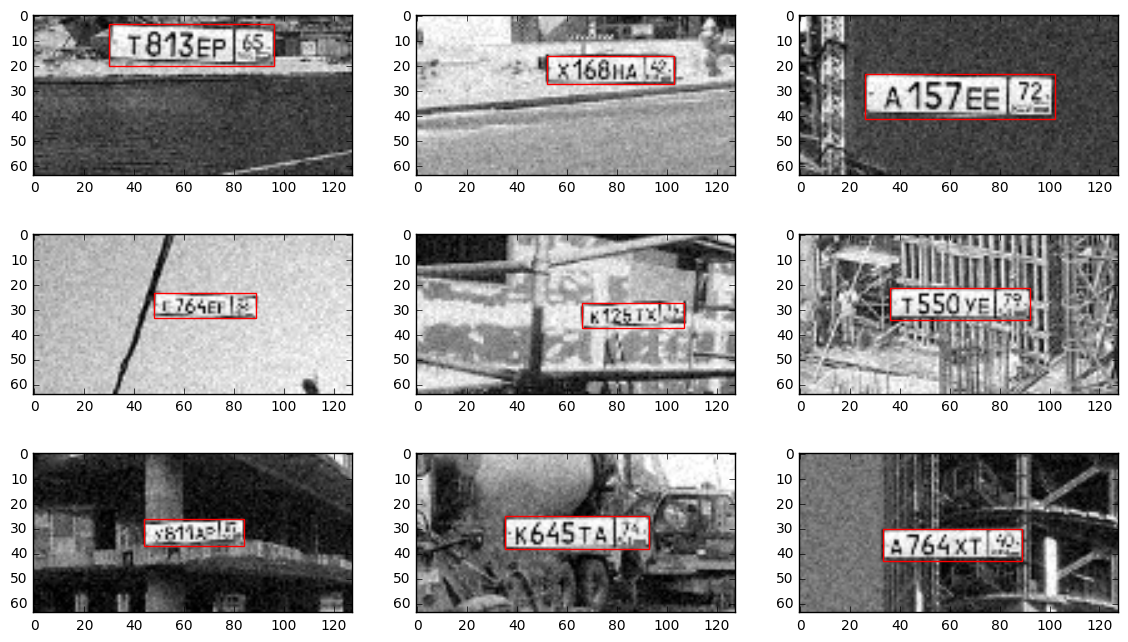

In [12]:
def show_image(image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='r', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    
def plot_images(images, labels):
    rcParams['figure.figsize'] = 14, 8
    plt.gray()
    fig = plt.figure()
    for i in range(min(9, images.shape[0])):
        fig.add_subplot(3, 3, i+1)
        show_image(images[i], labels[i])
    plt.show()    
    
xs = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]                   
plot_images(X_train[xs], Y_train[xs])  

## Batch iterator

In [13]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed

## Build Tensorflow neural net

In [14]:
def mse(expected, predicted):
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)

In [15]:
def weight_variable(name, shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.get_variable(name, initializer=initial)

def bias_variable(name, shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable(name, initializer=initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    

In [16]:
PIXEL_COUNT = X_train.shape[1] * X_train.shape[2]
LABEL_COUNT = Y_train.shape[1]
# Create placeholders for image data and expected point positions

class Model(object):
    xxx = 0
    
# Build neural network
def build_model():
    x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT])
    y_placeholder = tf.placeholder(tf.float32, shape=[None, LABEL_COUNT])

    x_image = tf.reshape(x_placeholder, [-1, 64, 128, 1])
    # Convolution Layer 1
    W_conv1 = weight_variable("w1", [3, 3, 1, 32])
    b_conv1 = bias_variable("b1", [32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    # Convolution Layer 2
    W_conv2 = weight_variable("w2", [2, 2, 32, 64])
    b_conv2 = bias_variable("b2", [64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    # Convolution Layer 3
    W_conv3 = weight_variable("w3", [2, 2, 64, 128])
    b_conv3 = bias_variable("b3", [128])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    # Dense layer 1
    h_pool3_flat = tf.reshape(h_pool3, [-1, 8*16*128])
    W_fc1 = weight_variable("w4", [8*16*128, 500])
    b_fc1 = bias_variable("b4", [500])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)    
    # Dense layer 2
    W_fc2 = weight_variable("w5", [500, 500])
    b_fc2 = bias_variable("b5", [500])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)    
    # Output layer
    W_out = weight_variable("w6", [500, LABEL_COUNT])
    b_out = bias_variable("b6", [LABEL_COUNT])
    
    output = tf.matmul(h_fc2, W_out) + b_out
    
    model = Model()
    model.x_placeholder = x_placeholder
    model.y_placeholder = y_placeholder
    model.output = output
    
    return model


# Define loss function
#model = build_model(x_placeholder)
#loss = mse(y_placeholder, model)

### Train

In [17]:
X2_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
Y2_train = Y_train / (64.0, 32.0, 64.0, 32.0) - 1.0

X2_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
Y2_test = Y_test / (64.0, 32.0, 64.0, 32.0) - 1

dataset = Dataset(X2_train, Y2_train)

In [18]:
Y2_test.shape

(216, 4)

In [19]:

#tf.Graph().as_default(), 

g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    
    model = build_model()
    loss = mse(model.y_placeholder, model.output)
    
    saver = tf.train.Saver()
    start_time = time.time()
    best_score = 1

    train_step = tf.train.AdamOptimizer().minimize(loss)

    session = tf.InteractiveSession()
    session.run(tf.global_variables_initializer())
    #saver.restore(session, os.path.join(MODEL_PATH, "model"))

    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={model.x_placeholder: batch_x, model.y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch:
            last_epoch = dataset.epoch_completed()
            score_test = loss.eval(feed_dict={model.x_placeholder: X2_test, model.y_placeholder: Y2_test})
            if score_test < best_score:
                best_score = score_test
                saver.save(session, os.path.join(MODEL_PATH, "model"))
            if dataset.epoch_completed() % 1 == 0:
                epm = 60 * dataset.epoch_completed() / (time.time()-start_time)
                print('Epoch: %d, Score: %f, Epoch per minute: %f' % (dataset.epoch_completed(), score_test, epm))
    print('Finished in %f seconds.' % (time.time()-start_time)) 
    
    session.close()

Epoch: 0, Score: 881.235107, Epoch per minute: 0.000000
Epoch: 1, Score: 0.042566, Epoch per minute: 6.938537
Epoch: 2, Score: 0.021955, Epoch per minute: 7.460956
Epoch: 3, Score: 0.014698, Epoch per minute: 7.647143
Epoch: 4, Score: 0.012928, Epoch per minute: 7.762977
Epoch: 5, Score: 0.008371, Epoch per minute: 7.842048
Epoch: 6, Score: 0.006337, Epoch per minute: 7.870665
Epoch: 7, Score: 0.005141, Epoch per minute: 7.907054
Epoch: 8, Score: 0.004091, Epoch per minute: 7.918574
Epoch: 9, Score: 0.003357, Epoch per minute: 7.937085
Epoch: 10, Score: 0.003187, Epoch per minute: 7.967353
Epoch: 11, Score: 0.003020, Epoch per minute: 7.981626
Epoch: 12, Score: 0.002416, Epoch per minute: 8.003309
Epoch: 13, Score: 0.002290, Epoch per minute: 8.019765
Epoch: 14, Score: 0.001989, Epoch per minute: 8.032450
Epoch: 15, Score: 0.002042, Epoch per minute: 8.073210
Epoch: 16, Score: 0.001812, Epoch per minute: 8.078772
Epoch: 17, Score: 0.001704, Epoch per minute: 8.086349
Epoch: 18, Score: 

### Show test set predictions

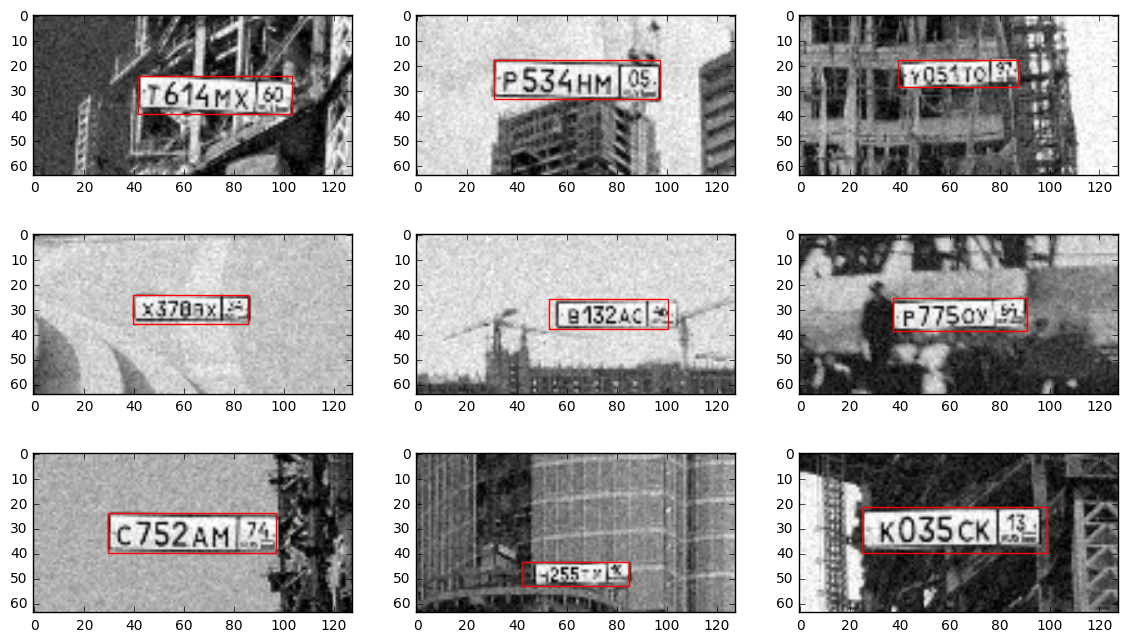

In [20]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    ids = [random.randint(0, X2_test.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_test[ids]})
    plot_images(X_test[ids], (predictions+1) * (64, 32, 64, 32))
    session.close()

### Show train set predictions

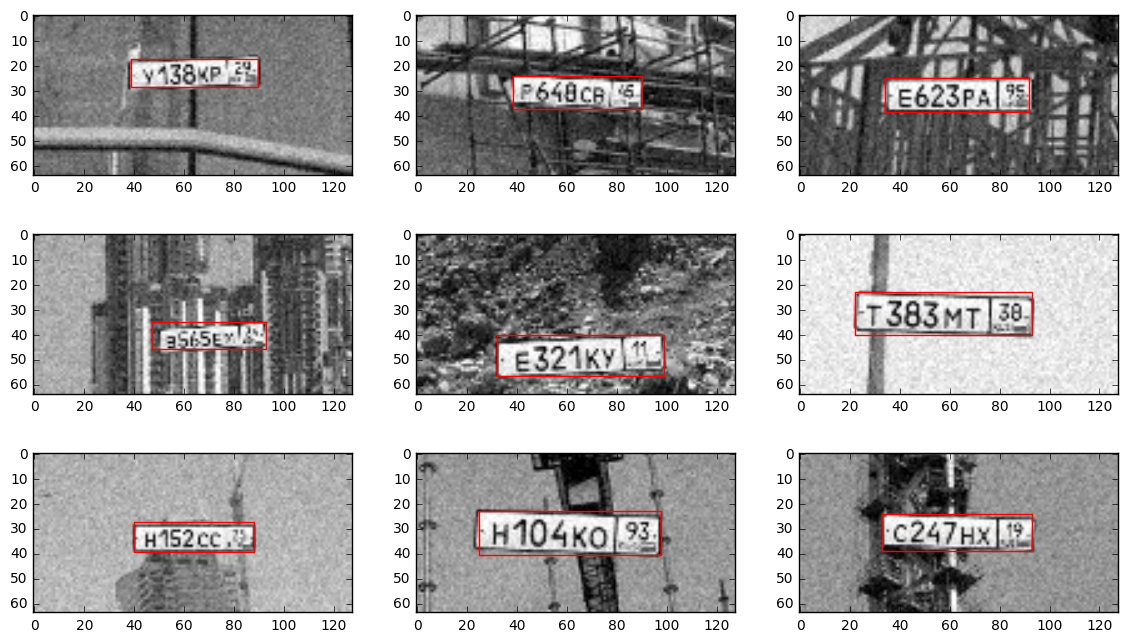

In [21]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    
    ids = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_train[ids]})
    plot_images(X_train[ids], (predictions+1) * (64, 32, 64, 32))

    session.close()